In [34]:
import torch as tr
import torch.nn as nn
from torch.optim.lr_scheduler import MultiStepLR
import matplotlib.pyplot as plt
import numpy as np

In [35]:
device = tr.device('cuda' if tr.cuda.is_available() else 'cpu')
# print(device)
# tr.set_default_dtype(tr.float)
# tr.set_default_device(device)

In [36]:
#hyperparameters
batch_size = 800
epoch = 400
t_update = 10
g = 0.8
max_steps = 350
dt = 0.0375 #time step size
target = [0.5,0]
deviation = 0.075
target_area = [[target[0]-deviation,target[0]+deviation],
               [target[1]-deviation,target[1]+deviation]]
U0 = 0.4
lstm_hidden_size = 0#8

In [37]:
def d(L):
    direction_mapping = [
        
        tr.tensor(0,dtype=tr.float).to(device),
        # tr.tensor(1/4 * tr.pi,dtype=tr.float).to(device),
        tr.tensor(tr.pi/2,dtype=tr.float).to(device), 
        # tr.tensor(3/4 * tr.pi,dtype=tr.float).to(device),
        tr.tensor(tr.pi,dtype=tr.float).to(device), 
        # tr.tensor(5/4*tr.pi,dtype=tr.float).to(device),
        tr.tensor(3/2 * tr.pi,dtype=tr.float).to(device),
        # tr.tensor(7/4 * tr.pi,dtype=tr.float).to(device)
    ]
    return tr.stack(direction_mapping).to(device)[L]

def U(U0,x,y):
    bool = (x**2+y**2)**0.5>0.5
    P = 16*U0*(x**2+y**2-0.25)**2
    P[bool] = 0
    return P
    
def force(x,y,type='mexican'):
    if type == 'lorenzian':
        if isinstance(x, tr.Tensor):
            F_x = tr.zeros(y.shape).to(device)
            F_y = U0/(1+6*x**2)
            return F_x, F_y
        else:
            U,V = np.zeros(y.shape), U0/(1+6*x**2)
            return U,V
    if type == 'mexican':
        if isinstance(x, tr.Tensor):
            r = tr.sqrt(x**2+y**2)
            bool = r>0.4
            fr = -64*U0*(r**2-0.25)
            fr[bool] = 0
            # f = tr.stack([fr*x,fr*y],dim=1).to(device)
            F_x = fr*x
            F_y = fr*y
            return F_x,F_y
        else:
            r = np.sqrt(x**2+y**2)
            bool = r>0.5
            fr = -64*U0*(r**2-0.25)
            fr[bool] = 0
            U,V = fr*x,fr*y
            #U,V = x*U0/sigma**2*np.exp(-1/(2*sigma**2)*(x**2+y**2)), y*U0/sigma**2*np.exp(-1/(2*sigma**2)*(x**2+y**2))
            return U,V

In [38]:
#Agent Class
class Agent(nn.Module):
    def __init__(self, x, y):#initialize agent at location (-0.5,-0.5) with bias 0
        super(Agent, self).__init__()
        self.x=x #x coordinate
        self.y=y #y coordinate
        # self.theta = tr.tensor(0,dtype=tr.float) #orientation
        self.flag = False #Flag to check if an agent has reached target area
        self.winner_index = 0
        #Layers:
        self.layers = nn.Sequential(
            nn.Linear(4+lstm_hidden_size, 32,dtype=tr.float),
            nn.LeakyReLU(),
            nn.Linear(32,32,dtype=tr.float),
            nn.LeakyReLU(),
            nn.Linear(32,4,dtype=tr.float)
        )
        # self.lstm = nn.LSTM(4,lstm_hidden_size,1, batch_first = True)

    def forward(self, x): #forward pass
        # lstm_output, (self.h,self.c) = self.lstm(x.unsqueeze(1),(self.h,self.c))
        # input = tr.cat((x,lstm_output.squeeze(1)),dim=1)

        frwd = self.layers(x)
        return frwd
    
    def init_LSTM(self):
        self.h = tr.zeros(1,batch_size,lstm_hidden_size).to(device)
        self.c = tr.zeros(1,batch_size,lstm_hidden_size).to(device)
    
    def detach_hc(self):
        self.h = self.h.detach()
        self.c = self.c.detach()
    # def detach_all(self):
    #     self.x.detach()
    #     self.y.detach()
    #     self.h.detach()
    #     self.c.detach()



    def move_reward(self,Q,F_x,F_y,epsilon): #Moves the agent (in-place) and returns the reward (out-of-place)
        L=tr.argmax(Q,dim=1).to(device)

        #e-greedy
        random_vector = tr.rand(L.shape,dtype=tr.float).to(device)
        epsilon_bool = random_vector<epsilon
        L[epsilon_bool] = tr.randint(0,4,(1,),dtype=tr.int64).to(device) 

        #thermal fluctuaions
        


        theta = d(L)

        wall = 0.75*tr.ones(self.x.shape).to(device)
        e_x = tr.cos(theta)
        v_x = e_x + F_x
        x_new = self.x + v_x*dt
        
        wall_bool_x_left = -wall <= x_new
        wall_bool_x_right =  x_new <= wall
        wall_bool_x = wall_bool_x_left*wall_bool_x_right


        e_y = tr.sin(theta)
        v_y = e_y + F_y
        y_new = self.y + v_y*dt

        wall_bool_y_left = -wall <= y_new
        wall_bool_y_right =  y_new <= wall
        wall_bool_y = wall_bool_y_left*wall_bool_y_right

        wall_bool = wall_bool_x * wall_bool_y #Bool that has True entries if the move stays within the constraints
        
        #movement within constraints
        self.x[wall_bool] = x_new[wall_bool]
        self.y[wall_bool] = y_new[wall_bool]

        #punish for hitting wall
        wall_bool = tr.logical_not(wall_bool)
        reward_t = -tr.ones(self.x.shape,dtype = tr.float).to(device)*dt/100 #r=-dt
        reward_t[wall_bool] = -10 
        
        #Reward getting to the target area!
        target_bool_x_left = target_area[0][0] <= self.x
        target_bool_x_right = self.x <= target_area[0][1]
        target_bool_x = target_bool_x_left*target_bool_x_right

        target_bool_y_left = target_area[1][0] <= self.y
        target_bool_y_right = self.y <= target_area[1][1]
        target_bool_y = target_bool_y_left*target_bool_y_right

        target_bool = target_bool_x*target_bool_y
        reward_t[target_bool] = 100 #batch_size #Large reward that scales with batch_size


        if target_bool.sum()>0: 
            self.flag = True
            self.winner_index = tr.nonzero(target_bool)[0].item()
            # loosers_bool = tr.logical_not(target_bool)
            # sq_distances = (self.x-0.5)**2+self.y**2
            # reward_t[loosers_bool] = -10*sq_distances[loosers_bool]

        return reward_t

In [39]:
#Simulation Setup
def episode(agent,t_agent,t_update, max_steps,g,optimizer,epsilon):
    agent.flag = False
    agent.winner_index = 0
    X,Y = agent.x,agent.y
    Losses = np.array([])
    for dT in range(max_steps):
        optimizer.zero_grad()#zero gradients

        if dT%t_update==0:#update target agent every t_update steps
            t_agent.load_state_dict(agent.state_dict())

        F_x,F_y = force(agent.x,agent.y)

        state = tr.stack([agent.x, agent.y, 
                        F_x.to(device), F_y.to(device)], dim=1)#,
                        #tr.ones(agent.x.shape, dtype = tr.float).to(device)*0.5,
                        #tr.zeros(agent.x.shape, dtype = tr.float).to(device)], dim=1) #state ,                         tr.ones(agent.x.shape, dtype = tr.float).to(device)*0.5,                        tr.zeros(agent.x.shape, dtype = tr.float).to(device)
        Q1 = agent.forward(state)
        R = agent.move_reward(Q1,F_x,F_y,epsilon)

        t_agent.x = agent.x.clone()
        t_agent.y = agent.y.clone()
        t_F_x,t_F_y = force(t_agent.x,t_agent.y)
        state2 = tr.stack([t_agent.x, t_agent.y,
                        t_F_x.to(device), t_F_y.to(device)], dim=1)#,
                       # tr.ones(agent.x.shape, dtype = tr.float).to(device)*0.5,
                       # tr.zeros(agent.x.shape, dtype = tr.float).to(device)], dim=1) #state
        Q2 = t_agent.forward(state2)#.transpose(0,1)) #Q value of target agent
        
        

        maxQ1 = tr.max(Q1,dim=1)[0]
        maxQ2 = tr.max(Q2,dim=1)[0]

        #target Q value
        target = R + g*maxQ2 

        # coeff = (target + target.min())/(target + target.min()).sum()
        # error = (target - maxQ1)**2
        # loss = coeff.T@error
        
        criterion = nn.MSELoss()
        target.detach()
        loss = criterion(target,maxQ1)
        
        #backpropagate
        loss.backward()
        
        #update weights and detach                         
        optimizer.step()   
        # agent.detach_hc()
        # t_agent.detach_hc()
        
        Losses = np.append(Losses,loss.item())
        #save data to track agent                    
        newX = X.reshape(batch_size,-1)
        newY = Y.reshape(batch_size,-1)
        newx = agent.x[:,None]
        newy = agent.y[:,None]


        X = tr.cat((newX,newx),dim=1)
        Y = tr.cat((newY,newy),dim=1)
        
        if agent.flag == True: 
            # print('Target area reached')
            break
    Losses = np.array(Losses).mean()
    
    return X,Y, Losses

In [40]:
#Simulation

def simulation():
    # mu, sig = -0.5, 0.05
    # x = tr.randn(batch_size, dtype=tr.float).to(device)*sig + mu
    # y = tr.randn(batch_size, dtype=tr.float).to(device)*sig
    x = tr.zeros(batch_size,dtype = tr.float).to(device)-0.5
    y = tr.zeros(batch_size,dtype = tr.float).to(device)
    agent = Agent(x,y).to(device)

    t_agent = Agent(x,y).to(device)
    t_agent.load_state_dict(agent.state_dict()) #copies weights from agent to t_agent
    # t_agent.eval()

    optimizer = tr.optim.Adam(agent.parameters(), lr=0.01)

    interval = epoch//5
    milestones = [interval,interval*2,interval*3,interval*4]
    scheduler = MultiStepLR(optimizer,milestones, gamma = 0.8)

    X_total, Y_total,  = [],[]
    Loss_total = np.array([])
    for i in range(epoch):
        # agent.init_LSTM()
        # t_agent.init_LSTM()

        epsilon = 1-(i/epoch)*0.8
        X,Y,loss_mean = episode(agent, t_agent, t_update, max_steps, g, optimizer,epsilon)
        X_total.append(X)
        Y_total.append(Y)
        Loss_total = np.append(Loss_total,loss_mean)
        # agent.x = tr.randn(batch_size, dtype=tr.float).to(device)*sig + mu
        # agent.y = tr.randn(batch_size, dtype=tr.float).to(device)*sig
        agent.x = tr.zeros(batch_size,dtype = tr.float).to(device)-0.5
        agent.y = tr.zeros(batch_size,dtype = tr.float).to(device)
        Path_labels = []
        if i%(epoch//5) == epoch//5-1:
            x,y = X[agent.winner_index].detach().to('cpu').numpy(),Y[agent.winner_index].detach().to('cpu').numpy()
            print(i)
            if len(x) == max_steps+1: T = r'$\infty$'
            else: T = str(np.round(len(x)*dt,2))
            path_label = 'T(' + str(int(i)) +') = '+ T
            Path_labels.append(path_label)
            plt.plot(x,y,label=path_label)#,c=np.arange(len(x)),cmap='viridis',marker = '.')
        scheduler.step()


    plt.xlim(-0.8,0.8)
    plt.ylim(-0.8,0.8)
    plt.scatter(-0.5,0,c='black',label='start',marker='D')    
    plt.scatter(0.5,0,c='black',label='goal',marker='x')


    X1,Y1 = np.meshgrid(np.linspace(-1,1,100),np.linspace(-1,1,100))

    Potential = U(U0,X1,Y1)/U0
    # _,forcefield = force(X1,Y1)
    plt.imshow(Potential,cmap = 'Greys',extent=[-1,1,-1,1],origin='lower')
    colorbar = plt.colorbar()
    colorbar.set_label(r'$U/U_0$',labelpad=10)
    colorbar.set_ticks([0, 0.25, 0.5, 0.75, 1.0])

    #fig.clim(Potential.min(),Potential.max())
    # plt.title('Episode ' + str(int(i)))
    # context_legend = plt.legend(['start','goal'],loc='upper right')
    plt.legend(bbox_to_anchor=(1,-0.1),ncol=2)

    # plt.gca().add_artist(context_legend)

    plt.show()
    return agent, X_total, Y_total, Loss_total


79
159
239
319
399


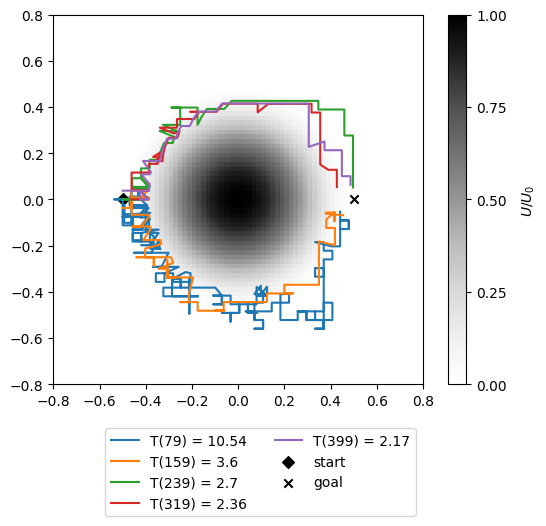

In [41]:
# for i in range(2):
agent, X_tot, Y_tot, Loss_total = simulation()     

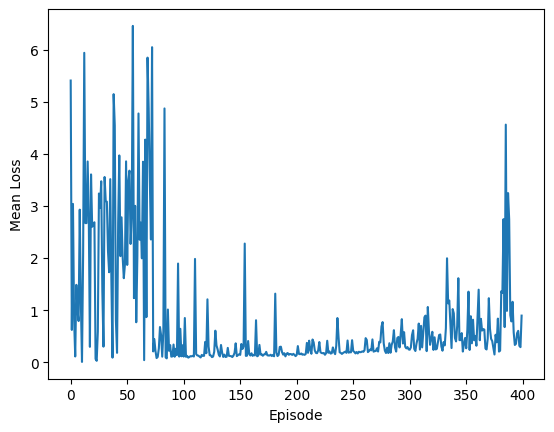

In [42]:
# print(Loss_total.shape)
X = np.linspace(0,Loss_total.shape[0]-1,Loss_total.shape[0])
plt.plot(X,Loss_total)
plt.ylabel('Mean Loss')
plt.xlabel('Episode')
plt.show()

In [43]:
# plt.xlim(-1,1)
# plt.ylim(-1,1)
# plt.scatter(-0.5,0,c='black',label='start',marker='D')    
# plt.scatter(0.5,0,c='black',label='goal',marker='x')

# X1,Y1 = np.meshgrid(np.linspace(-1,1,100),np.linspace(-1,1,100))
# Potential = U(U0,X1,Y1)/U0         
# plt.imshow(Potential,cmap = 'Greys',extent=[-1,1,-1,1],origin='lower')
# colorbar = plt.colorbar()
# colorbar.set_label(r'$U/U_0$',labelpad=10)
# colorbar.set_ticks([0, 0.25, 0.5, 0.75, 1.0])

# paths_legend = plt.legend(bbox_to_anchor=(1,-0.1),ncol=2)
# context_legend = plt.legend(loc = 'upper right')

# plt.gca().add_artist(paths_legend)

# plt.show()

In [44]:
# X1,Y1 = np.meshgrid(np.linspace(-1,1,100),np.linspace(-1,1,100))
# Fx,Fy = force(X1,Y1,type='lorenzian')

# plt.imshow(Fy/U0,cmap = 'Blues', extent = [-1,1,-1,1], origin = 'lower')
# colorbar = plt.colorbar()
# colorbar.set_ticks([0, 0.25, 0.5, 0.75, 1.0])
# plt.show()